# Simple predictive coding network implemented in Nengo

Toy model of predictive coding network implemented in Nengo.
The error signal teaches the integrator of upper hierarchy and becomes zero when finished teaching. The input signal and the signal from integrator specify the current error.

integrator part is taken from Nengo examples
https://www.nengo.ai/nengo/examples/dynamics/integrator.html

Integrator equation
dx/dt = u(t)
where u(t) is the input stimulus

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo
from nengo.processes import Piecewise

## Construct network

In [2]:
model = nengo.Network()

# Parameters
tau_synapse = 0.2 # should be reasonably large

with model:
    err = nengo.Ensemble(n_neurons=100, dimensions=1)
    layer1 = nengo.Ensemble(n_neurons=100, dimensions=1)
    stim = nengo.Node(Piecewise({0: 0, 0.2: 1, 4: -2, 8: 0.5}))
    layer2 = nengo.Ensemble(n_neurons=100, dimensions=1)
    nengo.Connection(stim,layer1)
    nengo.Connection(layer1, err)
    
    def forward(u):
        return tau_synapse*u
    # feedforward error
    nengo.Connection(err, layer2, function=forward, synapse=tau_synapse)
    
    def recurrent(x):
        return x
    nengo.Connection(layer2, layer2, function=recurrent, synapse=tau_synapse)
    
    nengo.Connection(layer2, err, transform=-1) # feedback to the error population

## Add probes

In [3]:
with model:
    layer1_probe = nengo.Probe(layer1, synapse=0.01)
    error_probe = nengo.Probe(err, synapse=0.01)
    layer2_probe = nengo.Probe(layer2, synapse=0.01)

## Run the model

In [4]:
# Create simulator
with nengo.Simulator(model) as sim:
    # Run it for several seconds
    sim.run(8)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

## Plot the results

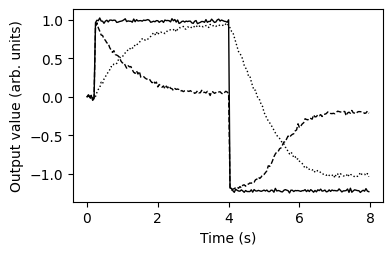

In [7]:
# Plot the decoded output of the ensemble
n = 40 # plot every n-th point
x = sim.trange()[::n]
y1 = sim.data[layer1_probe][::n]
y2 = sim.data[error_probe][::n]
y3 = sim.data[layer2_probe][::n]

fig = plt.figure(figsize=(4,2.5))
plt.plot(x, y1, "k", label="Layer 1 output", linewidth=1)
plt.plot(x, y2, "k", label="Error", linewidth=1, linestyle='dashed')
plt.plot(x, y3, "k", label="Layer 2 output", linewidth=1, linestyle='dotted')
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("Output value (arb. units)", fontsize=10)
#plt.legend(loc="upper right")

# save the figure if necessary
plt.savefig('Integrator.svg', bbox_inches='tight')

In [27]:
# save data for further use
import pandas as pd

data = {'time': sim.trange(),
        'layer1_output': sim.data[layer1_probe].squeeze(),
        'error': sim.data[error_probe].squeeze(),
        'layer2_output': sim.data[layer2_probe].squeeze()}
df = pd.DataFrame(data)
df.to_pickle('PCL_Nengo.pkl')
# df = pd.read_pickle('PCL_Nengo.pkl')